In [ ]:
### print best result
best_iter = np.argmax(np.asarray(results['accuracy'])[:,1])
best_param = grid_params[best_iter]
best_model = models[best_iter]
print(best_param)
print("loss={:.3f}, accuracy={:.3f}%".format(*results['accuracy'][best_iter]))

('glorot_uniform', 0.3, 'rmsprop')
loss=0.698, accuracy=0.774%


## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

**Answer:**  
What I tried:  
- Filter size: Applied with 5x5 and 3x3 while holding the output size unchanged respectively, I found that a model with small filter size shows better performance.  
- Number of filters: More filters significantly increased the accuracy by more than 2% on average.
- Regularization: Out of dropout rates `p=[0, 0.3, 0.5]`, a dropout with p=0.3 works best.
- Alternative initializers: The Xavier initialization works better than Variance Scaling and He Normal.
- Alternative optimizers: RMSprop with learning rate of 0.001 outperforms Adam optimizer.
- Network architecture: Based on AlexNet, the stack of 3x3 filters proposed in VGGNet is applied. Using Keras Functional API, the model generator combines 4 convolutional layers, 4 fully-connected layers with a given parameter set.


In [1]:
import os
import tensorflow as tf

import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

print('Using device: ', device)

Using device:  /device:GPU:0


In [3]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170508288/170498071 [==============================] - 4s 0us/step
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [4]:
seed = 231
tf.random.set_seed(seed)
@tf.function
def dset_generator(X, y, batch_size, shuffle=False):
    assert X.shape[0] == y.shape[0]
    if shuffle:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(X.shape[0], seed=seed, reshuffle_each_iteration=False).batch(batch_size)
        return dset
    dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch_size)
    return dset

In [5]:
train_dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=64)
val_dset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size=64)
test_dset =  tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size=64)

In [6]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

In [7]:
def model_generator(params):
    initializer, dropout = params
    layers = []
    num_channels = [128, 256, 256, 128] # 4 conv layers
    for n in num_channels:
        layers += [tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
                   tf.keras.layers.Conv2D(n, (3, 3), strides=(1, 1), padding='valid', 
                               activation='relu', kernel_initializer=initializer),
                   tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), 
                                      padding='valid', data_format=None),
                   tf.keras.layers.Dropout(dropout)]
    layers.append(tf.keras.layers.Flatten())
    num_hiddens = [4096, 2048, 512] # 3+1 fc layers
    for m in num_hiddens:
        layers.append(
            tf.keras.layers.Dense(m, activation='relu',
                                    kernel_initializer=initializer))
    layers.append(
        tf.keras.layers.Dense(10, activation='softmax',
                                kernel_initializer=initializer))
    model = tf.keras.Sequential(layers)
    return model

In [8]:
np.random.seed(231)
tf.random.set_seed(231)

from itertools import product
# hyperparameter set
initializers = ['VarianceScaling', 'glorot_uniform', 'HeNormal']
dropout_ratios = [0.3]
optims = ['rmsprop', 'adam']
grid_params = list(product(initializers, dropout_ratios, optims))

In [9]:
grid_params

[('VarianceScaling', 0.3, 'rmsprop'),
 ('VarianceScaling', 0.3, 'adam'),
 ('glorot_uniform', 0.3, 'rmsprop'),
 ('glorot_uniform', 0.3, 'adam'),
 ('HeNormal', 0.3, 'rmsprop'),
 ('HeNormal', 0.3, 'adam')]

In [ ]:
results = {'accuracy':[], 'history':[], 'params':[]}
print_every = 700
num_epochs = 10
batch_size = 128
models = []
i = 0
for initializer, dropout, optimizer in grid_params:
    print("{}th model with init={}, drop={}, optim={}".format(i+1, initializer, dropout, optimizer))
    model = model_generator((initializer, dropout))
    model.compile(optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val))    
    loss, acc = model.evaluate(X_test, y_test)
    if acc <= 0.5:
        print("something's worng in {}th model".format(i+1))
        break
    results['accuracy'].append((loss, acc))
    results['history'].append(history)
    models.append(model)
    i+=1

In [ ]:
for initializer, dropout, optimizer in grid_params[5:]:
    print("{}th model with init={}, drop={}, optim={}".format(5+1, initializer, dropout, optimizer))
    model = model_generator((initializer, dropout))
    model.compile(optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val))    
    loss, acc = model.evaluate(X_test, y_test)
    results['accuracy'].append((loss, acc))
    results['history'].append(history)
    models.append(model)

In [14]:
for loss, acc in results['accuracy']:
    print(loss, acc)

0.7433319091796875 0.760699987411499
0.7468932271003723 0.746399998664856
0.6980184316635132 0.774399995803833
0.6739726066589355 0.7717999815940857
0.8088476657867432 0.7257999777793884
0.8288841843605042 0.7247999906539917


In [20]:
best_iter = np.argmax(np.asarray(results['accuracy'])[:,1])
best_param = grid_params[best_iter]
best_model = models[best_iter]
print(best_param)
print("loss={:.3f}, accuracy={:.3f}%".format(*results['accuracy'][best_iter]))

('glorot_uniform', 0.3, 'rmsprop')
loss=0.698, accuracy=0.774%


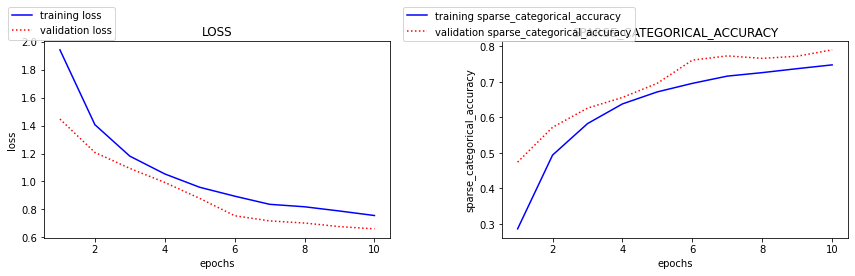

In [21]:
plot_history(results['history'][best_iter])